# Scandinavia - Airport analysis script
### Date: 13/7/2023

## Import libraries

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geoplot as gplt
import geopandas as gpd
from haversine import haversine, Unit
from matplotlib.font_manager import FontProperties

## Open csv file

In [3]:
country = "Scandinavia"

In [4]:
df1 = pd.read_csv('denmark_airports.csv')
# df2 = pd.read_csv('finland_airports.csv')
df3 = pd.read_csv('norway_airports.csv')
df4 = pd.read_csv('sweden_airports.csv')

# Read the files into dataframes
dfs = [df1, df3, df4]

g_airports = pd.concat(dfs, ignore_index=True)

In [5]:
print("Number of airports in Scandinavia is %s" % (len(g_airports)))

Number of airports in Scandinavia is 88


## Airport distance analysis

In [22]:
Haversine_dist = pd.DataFrame(index=g_airports.index, columns=g_airports.index)

# Calculate Haversine distances for each pair of airports
for start_airport_num in range(len(g_airports)):
    for finish_airport_num in range(len(g_airports)):
        if start_airport_num < finish_airport_num:  # Consider upper triangle and skip diagonal
            loc1 = (g_airports.iloc[start_airport_num].longitude_deg, g_airports.iloc[start_airport_num].latitude_deg)
            loc2 = (g_airports.iloc[finish_airport_num].longitude_deg, g_airports.iloc[finish_airport_num].latitude_deg)
            dist = haversine(loc1, loc2, unit=Unit.NAUTICAL_MILES)
            Haversine_dist.iloc[start_airport_num, finish_airport_num] = dist
        else:  # Put NaN in lower triangle and diagonal
            Haversine_dist.iloc[start_airport_num, finish_airport_num] = np.nan

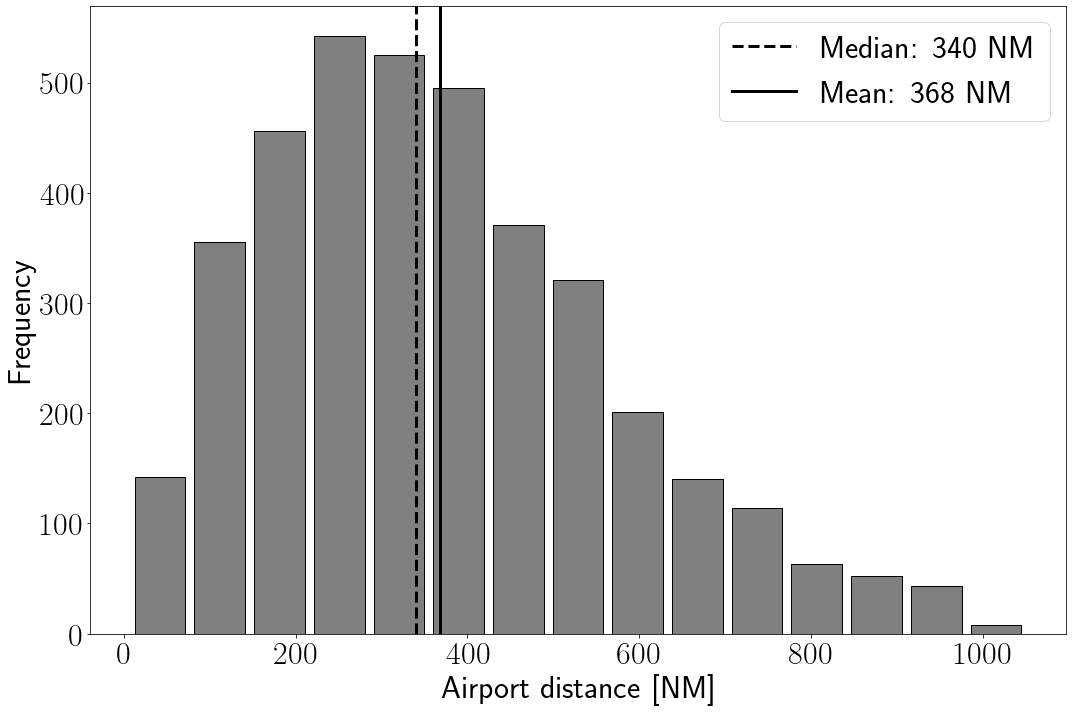

In [23]:
# Plot histogram of airport distance
# data = Haversine_dist.ravel()[~np.isnan(Haversine_dist.ravel())]
data = Haversine_dist.where(np.triu(np.ones(Haversine_dist.shape), k=1).astype(bool)).stack().values

plt.rcParams.update({
    "text.usetex": True,
})

ftsize = 32
plt.figure(figsize = [15,10])

plt.hist(data, bins=15,  color='gray', edgecolor = "black", alpha=1, rwidth=0.85, lw = 1)
plt.axvline(np.median(data), color='black', linestyle='dashed', linewidth=3, label = 'Median: {:.0f} NM'.format(np.median(data)))
plt.axvline(np.mean(data), color='black', linestyle='solid', linewidth=3, label = 'Mean: {:.0f} NM'.format(np.mean(data)))

min_ylim, max_ylim = plt.ylim()

# plt.title("Airport distance histogram - %s"%(country), fontsize = 18)
plt.xlabel('Airport distance [NM]', fontsize = ftsize)
plt.ylabel('Frequency', fontsize = ftsize)
plt.yticks(fontsize=ftsize)
# plt.xlim([0,2500])
plt.xticks(fontsize=ftsize)

plt.legend(fontsize = ftsize)
plt.tight_layout()

plt.savefig("plots/%s/distance_distribution_%s.png"%(country, country),
            pad_inches = 0.1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            dpi=800)

In [24]:
def calculate_lower_percentage(lst, number):
    lower_count = sum(1 for n in lst if n < number)
    lower_percentage = (lower_count / len(lst)) * 100
    return lower_percentage

In [25]:
percentage_lower = calculate_lower_percentage(data, 200)
print("The percentage of routes covered from a design mission of 200 NM is: {:.1f}%".format(percentage_lower))
percentage_lower = calculate_lower_percentage(data, 450)
print("The percentage of routes covered from a design mission of 450 NM is: {:.1f}%".format(percentage_lower))
percentage_lower = calculate_lower_percentage(data, 600)
print("The percentage of routes covered from a design mission of 600 NM is: {:.1f}%".format(percentage_lower))

The percentage of routes covered from a design mission of 200 NM is: 21.9%
The percentage of routes covered from a design mission of 450 NM is: 69.2%
The percentage of routes covered from a design mission of 600 NM is: 86.8%


In [26]:
print('Mean: {:.0f} [nm]'.format(np.mean(data)))
print('Median: {:.0f} [nm]'.format(np.median(data)))
print('Standard deviation: {:.0f} [nm]'.format(np.std(data)))

Mean: 368 [nm]
Median: 340 [nm]
Standard deviation: 202 [nm]


# Plot elevation of airports

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
})

ftsize = 32
plt.figure(figsize = [15,10])

plt.hist(g_airports.elevation_m.values*3.281, bins=15,  color='gray', edgecolor = "black", alpha=1, rwidth=0.85, lw = 1)
plt.axvline(np.median(g_airports.elevation_m.values*3.281), color='black',
            linestyle='dashed', linewidth=3, label = 'Median: {:.0f} ft'.format(np.median(g_airports.elevation_m.values*3.281)))
plt.axvline(np.mean(g_airports.elevation_m.values*3.281),
            color='black', linestyle='solid', linewidth=3, label = 'Mean: {:.0f} ft'.format(np.mean(g_airports.elevation_m.values*3.281)))

min_ylim, max_ylim = plt.ylim()

# plt.title("Airport distance histogram - %s"%(country), fontsize = 18)
plt.xlabel('Airport elevation [ft]', fontsize = ftsize)
plt.ylabel('Frequency', fontsize = ftsize)
plt.yticks(fontsize=ftsize)
plt.xlim([0,2000])
plt.xticks(fontsize=ftsize)

plt.legend(fontsize = ftsize)
plt.tight_layout()

plt.savefig("plots/%s/evelation_distribution_%s.png"%(country, country),
            pad_inches = 0.1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            dpi=800)

# Map visualization

C:\Users\deu01\AppData\Local\Temp/ipykernel_29372/2388927375.py:17: RuntimeWarning: invalid value encountered in less_equal
  reachable_airports = ((np.triu(Haversine_dist) <= max_distance)).sum(axis=1)


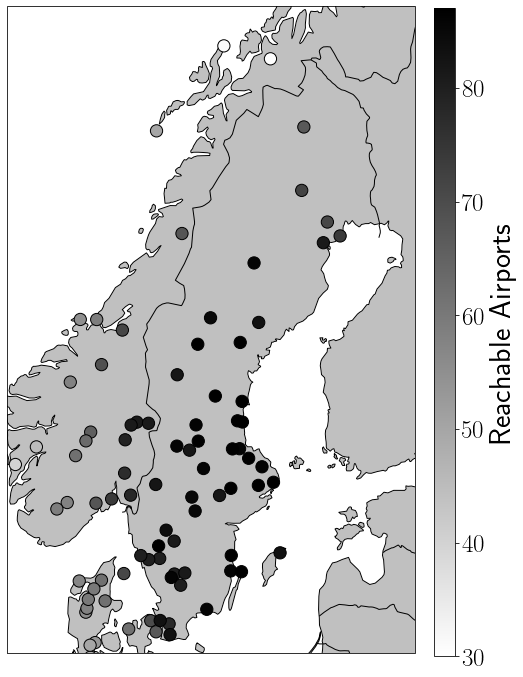

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from matplotlib.cm import ScalarMappable
# import shapely.geometry as sgeom
# from cartopy.geodesic import Geodesic

ftsize = 30

# Calculate number of reachable airports for each airport within 450 NM
max_distance = 450  # Maximum mission distance in NM
# Replace NaN values with a suitable value (e.g., -1) in the Haversine_dist DataFrame
# Haversine_dist = Haversine_dist.fillna(-1)
# Calculate reachable airports within the maximum distance
reachable_airports = ((np.triu(Haversine_dist) <= max_distance)).sum(axis=1)


# Filter out airports with less than 10 reachable airports
filtered_airports = g_airports[reachable_airports >= 0]

# Create the map figure and axes
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1, projection=ccrs.Mercator())

# Set the map boundaries for Scandinavia
ax.set_extent([5, 26, 55, 70], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cartopy.feature.LAND, facecolor='silver')
ax.add_feature(cartopy.feature.OCEAN, facecolor='white')
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black')

# Coordinates of Stockholm
# gd = Geodesic()
# stockholm_lon, stockholm_lat = 18.0686, 59.3293
# src_crs = ccrs.PlateCarree()
# geoms = []
# cp = gd.circle(lon=stockholm_lon, lat=stockholm_lat, radius=833400.)
# geoms.append(sgeom.Polygon(cp))
# ax.add_geometries(geoms, crs=src_crs, edgecolor='k', facecolor = 'none')

# Plot filtered airports on the map with color based on reachability
colors = reachable_airports[reachable_airports >= 0]
norm = plt.Normalize(colors.min(), colors.max())
cmap = plt.get_cmap('binary')
sm = ScalarMappable(cmap=cmap, norm=norm)
scatter = ax.scatter(
    filtered_airports.longitude_deg,
    filtered_airports.latitude_deg,
    transform=ccrs.PlateCarree(),
    s=150,  # Set a fixed point size
    marker='o',
    c=colors,
    cmap=cmap,
    norm=norm,
    edgecolor='black',
    zorder=5
)

# Add a colorbar for point colors
ax_cbar = fig.add_axes([0.52, 0.2, 0.02, 0.6])
cbar = plt.colorbar(sm, cax=ax_cbar, orientation='vertical')
cbar.set_label('Reachable Airports', fontsize=ftsize)
cbar.ax.tick_params(labelsize=ftsize-5)  # Set colorbar tick font size

# Adjust spacing between subplots
fig.subplots_adjust(wspace=0.05)

# Show the map
plt.savefig("plots/%s/Reachability_%s.png" % (country, country),
            bbox_inches="tight",
            pad_inches=0.1,
            transparent=False,
            facecolor="w",
            edgecolor='w',
            dpi=300)
